In [1]:
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from scipy.optimize import curve_fit

In [2]:
path = Path.cwd()
date = "2022-02-22"
datapath = path / (date+'_TK-data')
outputpath = path / 'results'

In [60]:
u = 1.6605 * 1e-27
m85 = 84.91 * u	
m87 = 86.91 * u	 
c = 299792458
kB = 1.380649 * 1e-23
h = 6.62607015 *1e-34

In [4]:
def loading(t,L,alpha):
    return L/alpha * (1-np.exp(-alpha*t))
def loading_nonzero(t,L,alpha,beta):
    return L/alpha * (1-beta * np.exp(-alpha*t))

In [5]:
data = pd.read_csv(datapath/(date+"_MOT_loading.csv"),header=2,skiprows=[8],sep=';')

In [6]:
data

,Relative time,HS3-100(17654).Ch2,HS3-100(17654).Ch1
0,0.0000,0.032031,3.333984
1,0.0003,0.027734,3.328125
2,0.0006,0.031250,3.320312
3,0.0009,0.026562,3.330078
4,0.0012,0.029297,3.324219
...,...,...,...
99995,29.9985,0.236719,0.029297
99996,29.9988,0.227344,0.031250
99997,29.9991,0.236719,0.027344
99998,29.9994,0.237891,0.029297


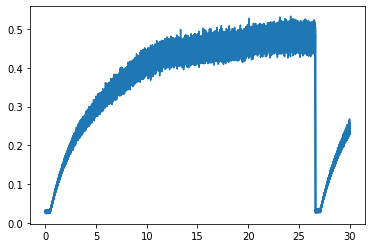

In [24]:
plt.plot(data['Relative time'],data['HS3-100(17654).Ch2'])

# Determination of Atom Number

## Voltage to Power Conversion

In [46]:
V_out = data['HS3-100(17654).Ch2']
SF = 10 * 1e6/(10*1e6+50) #scale factor
TG = 2.38 * 1e6 #V/A #Transimpedance gain
TG_err = 0.05 * TG #5% error
R = 0.48 #Wellenlänge lambda = 780 nm
R_err = 0.01

In [100]:
Pmeas = V_out /(R * TG * SF)
Pmeas_err = np.sqrt((V_out*R_err/(R**2*TG*SF))**2+(V_out*TG_err/(R*TG**2*SF))**2)

## Scattering Rate

In [106]:
Delta = 10 * 1e6 #10 MHz detuning
Gamma0 = 2*np.pi*6.07 *1e6 #2pi * 6.07 MHz natural line width
Isat = 4.1 *1e-3*1e4 # 4.1 mW/cm^2
P_pm = 15 * 1e-3 # P_Powermeter = 5 +/- 0.1 mW je Richtung
P_pm_err = np.sqrt(3)*0.1*1e-3 #siehe oben
w = 2*1e-3 #waist 2 mmm
I0 = 2*P_pm/(np.pi*w**2) #Ir \approx I0 Ist das richtig so? oder Faktor 3 daneben?
I0_err = 2*P_pm_err/(np.pi*w**2)

In [102]:
Gamma_sc = Gamma0/2 * I0/Isat /(1+I0/Isat+4*Delta**2/Gamma0**2)
Gamma_sc_err = Gamma0/(2*Isat) * (1+4*Delta**2/Gamma0**2)/(1+I0/Isat*4*Delta**2/Gamma0**2) * I0_err

## Atom Number

In [103]:
theta = (25.4)**2/(4*(150)**2) #according to Praktikumsanleitung
E = h*c/(780.241*1e-9) #5S1/2 -> 5P3/2 Übergang aprrox 780.241 nm

In [104]:
N = Pmeas/(theta*Gamma_sc*E)
N_err = np.sqrt((Pmeas_err/(theta*Gamma_sc*E))**2+(Pmeas*Gamma_sc_err/(theta*Gamma_sc**2*E))**2)

# Loading Curve & Fit

Trigger times:

1666      0.4998
88762    26.6286
90428    27.1284
Name: Relative time, dtype: float64


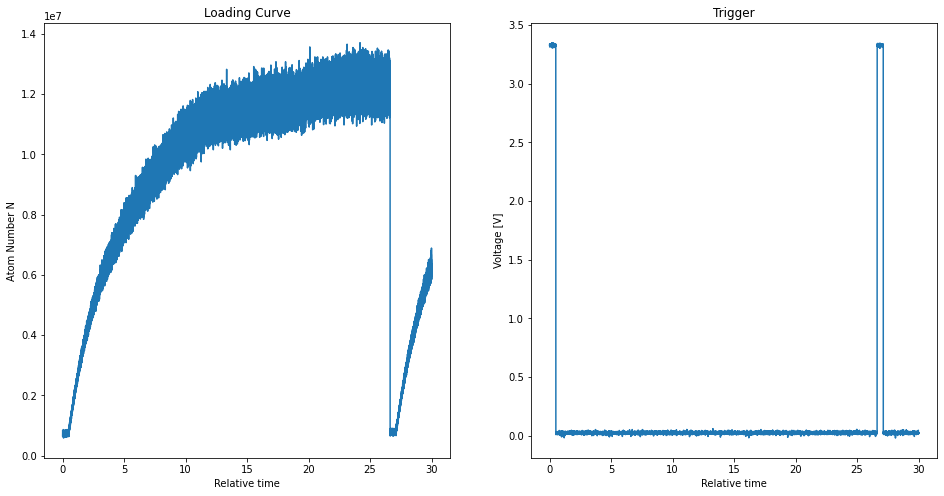

In [109]:
#Inspect and set fit boundaries
fig, (ax1, ax2) = plt.subplots(1, 2,figsize = (16,8))
ax1.plot(data['Relative time'],N)
ax2.plot(data['Relative time'],data['HS3-100(17654).Ch1'],)
ax1.set_xlabel('Relative time')
ax1.set_ylabel('Atom Number N')
ax2.set_xlabel('Relative time')
ax2.set_ylabel('Voltage [V]')
ax1.set_title('Loading Curve')
ax2.set_title('Trigger')
diff = np.array([abs(data['HS3-100(17654).Ch1'][i+1]-data['HS3-100(17654).Ch1'][i]) for i in range(0,data.shape[0]-1)])
diff = np.concatenate((diff,[False]))
print("Trigger times:\n")
print(data['Relative time'][diff > 1])
plt.show()

In [111]:
start = data.index[diff > 1][0]+1
stop = data.index[diff > 1][1]

res = 104669636.454370
L = 2431150.22621 +/- 1347.104773, alpha = 0.19978 +/- 0.000133


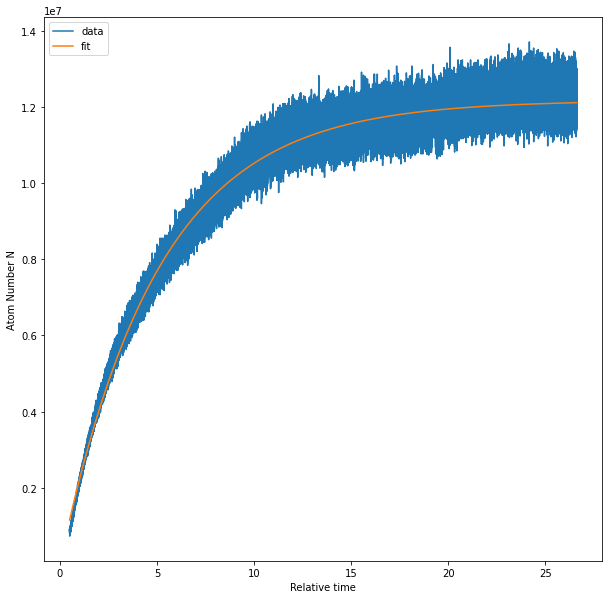

In [136]:
popt, pcov = curve_fit(loading,data['Relative time'][start:stop],N[start:stop],bounds=([1,0],[1e9,1]))
perr = np.sqrt(np.diag(pcov))
plt.figure(figsize = (10,10))
plt.plot(data['Relative time'][start:stop],N[start:stop],label='data')
plt.plot(data['Relative time'][start:stop], loading(data['Relative time'][start:stop],*popt),label='fit')
plt.xlabel('Relative time')
plt.ylabel('Atom Number N')
plt.legend()
print("res = {:f}".format(np.sqrt(np.sum((loading(data['Relative time'][start:stop],*popt)-N[start:stop])**2))))
print("L = {:.5f} +/- {:5f}, alpha = {:.5f} +/- {:5f}".format(popt[0],perr[0],popt[1],perr[1]))

## Comparison: Fit modified curve for N(0)!=0

res = 104640825.117936
L = 2418639.12485 +/- 2228.813054, alpha = 0.19865 +/- 0.000209, beta = 0.99582 +/- 0.000599


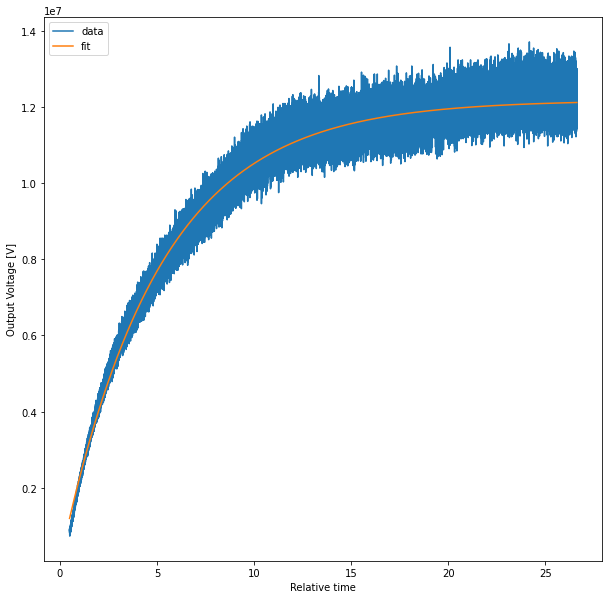

In [143]:
popt, pcov = curve_fit(loading_nonzero,data['Relative time'][start:stop],N[start:stop],bounds=([1,0,-10],[1e9,1,10]))
perr = np.sqrt(np.diag(pcov))
plt.figure(figsize = (10,10))
plt.plot(data['Relative time'][start:stop],N[start:stop],label='data')
plt.plot(data['Relative time'][start:stop], loading_nonzero(data['Relative time'][start:stop],*popt),label='fit')
plt.xlabel('Relative time')
plt.ylabel('Output Voltage [V]')
plt.legend()
print("res = {:f}".format(np.sqrt(np.sum((loading_nonzero(data['Relative time'][start:stop],*popt)-N[start:stop])**2))))
print("L = {:.5f} +/- {:5f}, alpha = {:.5f} +/- {:5f}, beta = {:.5f} +/- {:5f}".format(popt[0],perr[0],popt[1],perr[1],popt[2],perr[2]))